In [3]:
#Choose GPUs and CPUs

#If want to choose GPU to use
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1,4"
#This will make it so that only the 0th GPU is visible to TensorFlow.
#In your case, you can choose any in the range [0, 3].
#If you wanted, for example, the 0th and 2nd GPUs to both be visible, replace "0" with "0,2"

import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import mnist


GPU=True
CPU=False
num_cores = 8

if GPU:
    num_GPU = 1
    num_CPU = 2
if CPU:
    num_CPU = num_cores
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
config.gpu_options.allow_growth = True

session = tf.Session(config=config)
K.set_session(session)


In [70]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle


from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import to_categorical

from tqdm import tqdm_notebook, tnrange

import cv2
from scipy.fftpack import fftn,fftshift


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# Load MNIST data from Keras

In [119]:

# input image dimensions
img_rows, img_cols = 28, 28
num_classes=10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

train_dataset = x_train.astype('float32')
test_dataset = x_test.astype('float32')
train_dataset /= 255
test_dataset /= 255
print('train_dataset shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
train_labels = keras.utils.to_categorical(y_train, num_classes)
test_labels = keras.utils.to_categorical(y_test, num_classes)


train_dataset shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Pad numpy array 
Want get 36x36 which is how much the multiMNIST will be

In [120]:
train_dataset=np.pad(train_dataset, ((0,0),(4,4),(4,4),(0,0)), 'constant', constant_values=(0,0))
print (train_dataset.shape)

test_dataset=np.pad(test_dataset, ((0,0),(4,4),(4,4),(0,0)), 'constant', constant_values=(0,0))
print (test_dataset.shape)

(60000, 36, 36, 1)
(10000, 36, 36, 1)


# Augment the data with rotations and translations

In [121]:
aug_data=[]
aug_labels=[]
cols, rows=36,36

dims=train_dataset.shape
#Rotations, 1 each
ang = (np.random.rand(dims[0]))*30+5
print ("Doing rotations")
for i in tqdm_notebook(range(dims[0])):
    M = cv2.getRotationMatrix2D((cols/2,rows/2),ang[i],1)
    tmp = cv2.warpAffine(train_dataset[i-1],M,(cols,rows))
    aug_data.append(tmp)
    aug_labels.append(train_labels[i])


print ("Doing displacements")
rows,cols = dims[1],dims[2]

disps = (np.random.rand(dims[0],2))*5+1 # At least 1 pixel
print (min(disps[:,0]), max(disps[:,0]))
for i in tqdm_notebook(range(dims[0])):
    M = np.float32([[1,0,disps[i,0]],[0,1,disps[i,1]]])
    tmp = cv2.warpAffine(train_dataset[i],M,(cols,rows))
    aug_data.append(tmp)
    aug_labels.append(train_labels[i])
   

print ("Doing displacements and rotations")
#Both displace and rotate
ang = (np.random.rand(dims[0]))*30+5
disps = (np.random.rand(dims[0],2))*5+1 # At least 1 pixel
print (min(disps[:,0]), max(disps[:,0]))
for i in tqdm_notebook(range(dims[0])):
    M = np.float32([[1,0,disps[i,0]],[0,1,disps[i,1]]])
    tmp = cv2.warpAffine(train_dataset[i],M,(cols,rows))
    M = cv2.getRotationMatrix2D((cols/2,rows/2),ang[i],1)
    tmp = cv2.warpAffine(tmp,M,(cols,rows))
    aug_data.append(tmp)
    aug_labels.append(train_labels[i])

Doing rotations



Doing displacements
1.0000302009116304 5.9999829486631056



Doing displacements and rotations
1.000036701337498 5.999747238964373


In [122]:
aug_data=np.asarray(aug_data)
aug_labels=np.asarray(aug_labels)
print (aug_data.shape)
aug_data=np.reshape(aug_data,(aug_data.shape[0],36,36,1))

(180000, 36, 36)


In [123]:
all_data=np.concatenate([train_dataset,aug_data],axis=0)
all_labels=np.concatenate([train_labels,aug_labels],axis=0)
print (all_data.shape, all_labels.shape)

(240000, 36, 36, 1) (240000, 10)


# FT the training and test data

In [124]:
dims=all_data.shape
ft_train=[]
for i in tnrange(dims[0]):
    ft_train.append(np.abs(fftshift(fftn(all_data[i,:,:]))))

dims=test_dataset.shape
ft_test=[]
for i in tqdm_notebook(range(dims[0])):
    ft_test.append(np.abs(fftshift(fftn(test_dataset[i,:,:])))) #Don't forget to take abs!

ft_train=np.asarray(ft_train)
ft_test=np.asarray(ft_test)
print (ft_train.shape)
print (ft_test.shape)


(240000, 36, 36, 1)
(10000, 36, 36, 1)


<Figure size 432x288 with 0 Axes>

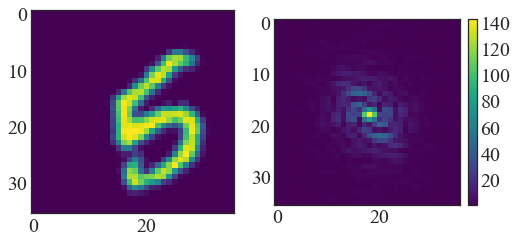

In [126]:
i=200000
plt.viridis()
f,axarr=plt.subplots(1,2,figsize=(8, 6))
axarr[0].imshow(all_data[i].squeeze())
img=axarr[1].imshow(ft_train[i].squeeze())
f.colorbar(img, fraction=0.046, pad=0.04)

# O.K now try CNN

In [127]:
dims=ft_train.shape
print (dims)
trainee=ft_train.reshape(dims[0],dims[1],dims[2],1)
dims=test_dataset.shape
testee=ft_test.reshape(dims[0],dims[1],dims[2],1)
print (trainee.shape)


np.random.seed(123)
model=Sequential()

model.add(Conv2D(32,(3,3), activation='relu', input_shape=(36,36,1),data_format='channels_last'))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

#parallel_model = ModelMGPU(model, gpus=num_GPU)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print (model.summary())
#print (parallel_model.summary())



checkpoints=keras.callbacks.ModelCheckpoint('tmp_models/weights.{epoch:02d}.hdf5', monitor='val_loss', 
                                verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history=model.fit(trainee, all_labels, batch_size=256, verbose=1, epochs=10, validation_split = 0.1, callbacks=[checkpoints])

(240000, 36, 36, 1)
(240000, 36, 36, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 34, 34, 32)        320       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 

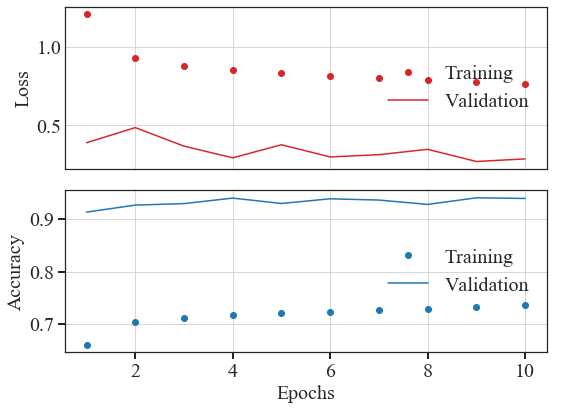

In [128]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(2, sharex=True, figsize=(8, 6))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.0, 0.5))


axarr[1].plot(epochs,hist.history['acc'], 'C0o', label='Training')
axarr[1].plot(epochs,hist.history['val_acc'], 'C0-', label='Validation')
plt.legend(loc='center right', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.grid()
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=7)
plt.tick_params(which='minor', length=5)

In [129]:
from keras.models import Model, load_model
model=load_model('tmp_models/weights.08.hdf5')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score=model.evaluate(testee, test_labels, verbose=1)
print (score)

 9600/10000 [===========================>..] - ETA: 0s[0.1481072497110581, 0.9609]


In [116]:
preds=(model.predict(testee))

6


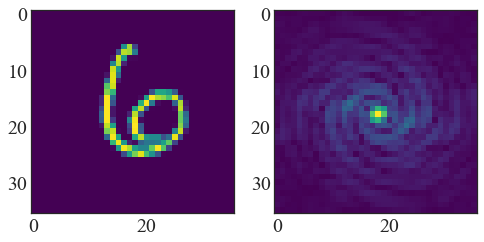

In [117]:
i=100
f,axarr=plt.subplots(1,2,figsize=(8, 6))
axarr[0].imshow(test_dataset[i].squeeze(),cmap='viridis')
axarr[1].imshow(testee[i].squeeze(), cmap='viridis')
print (np.argmax(preds[i]))